In [1]:
### Benjamin Tollison ###
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sympy as sp
from IPython.display import Latex, Math, display
from sympy import (
    Eq,
    Function,
    Matrix,
    cos,
    cosh,
    exp,
    integrate,
    lambdify,
    pi,
    sin,
    sinh,
    symbols,
)
from decimal import Decimal
from sympy.solvers.pde import pdsolve
from sympy.solvers.solveset import linsolve
import ExponentialDecayModel as edm
def displayEquations(LHS,RHS):
    left = sp.latex(LHS)
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
    np.set_printoptions(suppress=True)
def displayVariable(variable:str,RHS):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
def displayVariableWithUnits(variable:str,RHS,units):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    latexUnit = sp.latex(symbols(units))
    display(Math(left + '=' + right + '\\;' +'\\left['+ latexUnit + '\\right]'))
def format_scientific(number:float):
    a = '%E' % number
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]
deg2rad = np.pi/180
rad2deg = 180/np.pi

### 1)

In [2]:
ft2km = 0.000305
ft2m = 0.3048
mass = 6000 / 2.205
figure_of_merit = 0.75
thrust_req = mass * 9.81
density_sea_level, density_5k_ft, density_10k_ft = edm.Density(0), edm.Density(5000*ft2km), edm.Density(10000*ft2km)
density_list = [density_sea_level,density_5k_ft,density_10k_ft]
rotor_area = np.pi*(21*ft2m)**2
velocity_climb_list = [(ft2m/60)*i for i in [-600,-300,0,300,600]]
def PowerHover(density:float):
  power_ideal = thrust_req**1.5 / (2*density*rotor_area)**0.5
  return power_ideal/figure_of_merit
def VelocityHover(density:float):
  return (thrust_req / (2*density*rotor_area))**0.5
def NegativeVelocityInducedRatio(velocity_climb:float, velocity_hover:float):
  alef = velocity_climb/velocity_hover
  k1,k2,k3,k4 = -1.125,-1.372,-1.718,-0.655
  return 1 + k1*alef + k2*alef**2 + k3*alef**3 + k4*alef**4
def PowerClimb(velocity_climb:float,density:float):
  velocity_hover = VelocityHover(density)
  if velocity_climb/velocity_hover >= -2 and velocity_climb/velocity_hover <= 0:
    velocity_induced = NegativeVelocityInducedRatio(velocity_climb,velocity_hover)*velocity_hover
  else:
    alef = (-1/2)*(velocity_climb/(2*velocity_hover)) + ((velocity_climb/(2*velocity_hover))**2 + 1)**0.5
    velocity_induced = alef*velocity_hover
  power_climb_ideal = thrust_req*(velocity_climb + velocity_induced)
  return power_climb_ideal / figure_of_merit
# sanity check
displayVariable('v_h',VelocityHover(density_sea_level))
displayVariable('P_{c(v_c=0,\\rho=1.225)}',PowerClimb(0,density_sea_level))
displayVariable('P_h(v_c=0)',PowerHover(density_sea_level))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,sea_level,5k,10k
0,309587.523820,347650.955681,389798.612630
1,324312.831175,361424.002900,402521.238559
2,327464.327358,363786.096301,404136.612161
3,369266.973064,405477.126429,445727.082650
4,413289.249616,449170.652123,489123.397163


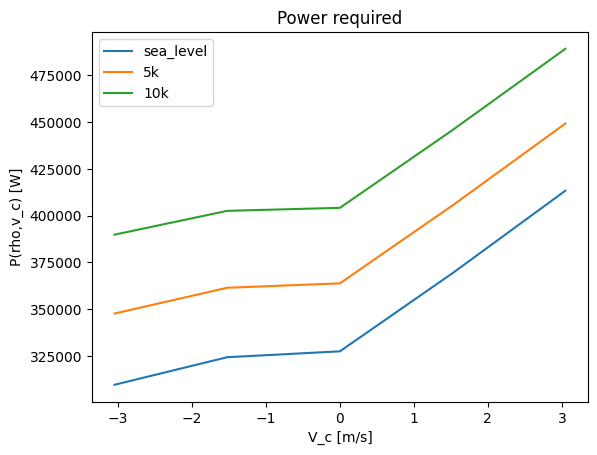

In [3]:
power_dict = {}
power_dict['sea_level'] = [PowerClimb(i,density_sea_level) for i in velocity_climb_list]
power_dict['5k'] = [PowerClimb(i,density_5k_ft) for i in velocity_climb_list]
power_dict['10k'] = [PowerClimb(i,density_10k_ft) for i in velocity_climb_list]
display(pd.DataFrame(power_dict))
for i in power_dict.keys():
  plt.plot(velocity_climb_list,power_dict[str(i)],label=i)
plt.title('Power required')
plt.xlabel('V_c [m/s]')
plt.ylabel('P(rho,v_c) [W]')
plt.legend()
plt.show()

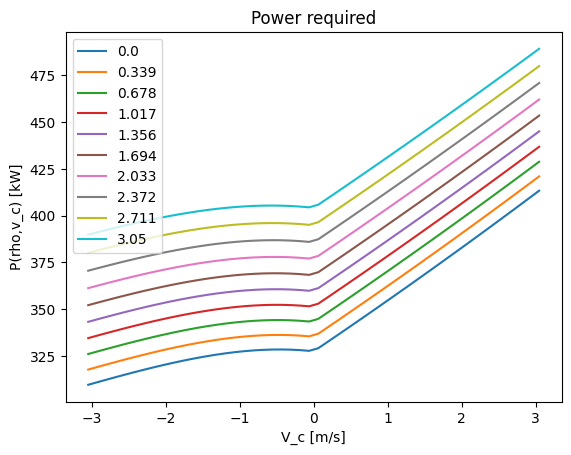

In [4]:
# making smoother curves
power_function_dict = {}
for altitude in np.linspace(0, 10000*ft2km, 10):
  power_function_dict[str(altitude)] = [PowerClimb(velocity,edm.Density(altitude))*10**-3 for velocity in np.linspace(velocity_climb_list[0],velocity_climb_list[-1],50)]
for i in power_function_dict.keys():
  plt.plot(np.linspace(velocity_climb_list[0],velocity_climb_list[-1],50),power_function_dict[i],label=str(round(float(i),3)))
plt.title('Power required')
plt.xlabel('V_c [m/s]')
plt.ylabel('P(rho,v_c) [kW]')
plt.legend()
plt.show()

### 2)
Using the same helicopter to for finding induced flow

In [5]:
coefficient_thrust = 0.01
velocity_tip = lambda rho: (thrust_req/(rho*rotor_area*coefficient_thrust))**0.5
displayVariableWithUnits('\\Omega{R}',velocity_tip(density_sea_level),'\\frac{m}{s}')
def AdvanceRatio(
  rotor_tip_velocity:float,
  freestream_velocity:float,
  angle_of_attack:float
)->float:
  v_tip = rotor_tip_velocity
  v_infty = freestream_velocity
  alpha = angle_of_attack
  mu = v_infty * np.cos(alpha) / v_tip
  return mu
mu_sea_level = AdvanceRatio(velocity_tip(density_sea_level),VelocityHover(density_sea_level)*10,0)
alef = np.array([-0.5 * mu_sea_level**2 + 0.5*(mu_sea_level**4 + coefficient_thrust**2)**0.5,
                -0.5 * mu_sea_level**2 - 0.5*(mu_sea_level**4 + coefficient_thrust**2)**0.5])
displayVariable('\\alef',alef)
inflow_zero = np.array([
  np.emath.sqrt(alef),
  -np.emath.sqrt(alef)
])
displayVariable('\\lambda_0',inflow_zero)
for i in inflow_zero.real:
  if i[0] > 0.0:
    displayVariable('\\lambda_{\\alpha=0}',i[0])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
### fixed point
fixed_point_dict = {}
def FixedPointError(inflow_ratio,advance_ratio,angle_of_attack):
  mu = advance_ratio
  alpha = angle_of_attack
  error = mu*np.tan(alpha) + coefficient_thrust / (2*np.sqrt(inflow_ratio**2 + mu**2)) - inflow_ratio
  return float(error)
def FixedPointNumeric(angle_of_attack):
  inflow_hover = (coefficient_thrust/2)**0.5
  iteration_count = 0
  inflow_fixed_point = inflow_hover
  advance_fixed = mu_sea_level
  alpha = angle_of_attack
  fixed_point_dict[f'{alpha}'] = {
    'error':[],
    'inflow_i':[],
    'inflow_i+1':[]
  }
  while abs(FixedPointError(inflow_fixed_point,advance_fixed,alpha)) > 1e-8:
    iteration_count += 1
    fixed_point_dict[f'{alpha}']['error'].append(FixedPointError(inflow_fixed_point,advance_fixed,alpha))
    fixed_point_dict[f'{alpha}']['inflow_i'].append(inflow_fixed_point)
    inflow_fixed_point = float(advance_fixed*np.tan(alpha) + coefficient_thrust/(2*np.sqrt(inflow_fixed_point**2+advance_fixed**2)))
    fixed_point_dict[f'{alpha}']['inflow_i+1'].append(inflow_fixed_point)
  # display(pd.DataFrame(fixed_point_dict))
for i in range(-4,9,2):
  FixedPointNumeric(i*deg2rad)
for alpha, values in fixed_point_dict.items():
    df = pd.DataFrame(values)
    print(f"Results for Angle of Attack: {round(float(alpha)*rad2deg,2)} degrees")
    display(df)  # Display each DataFrame for each angle of attack
    print("\n")

Results for Angle of Attack: -4.0 degrees


,error,inflow_i,inflow_i+1
0,-1.131204e-01,0.070711,-0.042410
1,2.240865e-05,-0.042410,-0.042387
2,1.336422e-08,-0.042387,-0.042387




Results for Angle of Attack: -2.0 degrees


,error,inflow_i,inflow_i+1
0,-0.088367,0.070711,-0.017657
1,0.000033,-0.017657,-0.017624




Results for Angle of Attack: 0.0 degrees


,error,inflow_i,inflow_i+1
0,-0.063675,0.070711,0.007036
1,0.000035,0.007036,0.007071




Results for Angle of Attack: 2.0 degrees


,error,inflow_i,inflow_i+1
0,-3.898199e-02,0.070711,0.031729
1,2.798458e-05,0.031729,0.031757
2,-1.252466e-08,0.031757,0.031757




Results for Angle of Attack: 4.0 degrees


,error,inflow_i,inflow_i+1
0,-1.422898e-02,0.070711,0.056482
1,1.264174e-05,0.056482,0.056494
2,-1.000309e-08,0.056494,0.056494




Results for Angle of Attack: 6.0 degrees


,error,inflow_i,inflow_i+1
0,1.064521e-02,0.070711,0.081356
1,-1.124990e-05,0.081356,0.081345
2,1.268986e-08,0.081345,0.081345




Results for Angle of Attack: 8.0 degrees


,error,inflow_i,inflow_i+1
0,3.570267e-02,0.070711,0.106413
1,-4.364411e-05,0.106413,0.106370
2,6.349866e-08,0.106370,0.106370


In [7]:
# Newton-Raphson
newton_raphson_dict = {}
def Error(inflow_ratio,advance_ratio,angle_of_attack):
  mu = advance_ratio
  alpha = angle_of_attack
  error = mu*np.tan(alpha) + coefficient_thrust / (2*np.sqrt(inflow_ratio**2 + mu**2)) - inflow_ratio
  return float(error)
def NewtonRaphon(angle_of_attack):
  tolerance = 1e-8
  inflow_hover = (coefficient_thrust/2)**0.5
  iteration_count = 0
  inflow_newton = inflow_hover
  advance_newton = mu_sea_level
  alpha = angle_of_attack
  newton_raphson_dict[f'{alpha}'] = {
    'error':[],
    'inflow_i':[],
    'inflow_i+1':[]
  }
  while abs(Error(inflow_newton,advance_newton,alpha)) >= tolerance and iteration_count < 30:
    iteration_count += 1
    newton_raphson_dict[f'{alpha}']['error'].append(Error(inflow_newton,advance_newton,alpha))
    newton_raphson_dict[f'{alpha}']['inflow_i'].append(inflow_newton)
    f =  Error(inflow_newton,advance_newton,alpha)
    f_prime = 1 + (coefficient_thrust/2)*(advance_newton**2+inflow_newton**2)**-3/2 * inflow_newton
    inflow_newton = inflow_newton + f/f_prime
    newton_raphson_dict[f'{alpha}']['inflow_i+1'] = inflow_newton
for i in range(-4,9,2):
  NewtonRaphon(i*deg2rad)
for alpha, values in newton_raphson_dict.items():
    df = pd.DataFrame(values)
    print(f"Results for Angle of Attack: {round(float(alpha)*rad2deg,2)} degrees")
    display(df)  # Display each DataFrame for each angle of attack
    print("\n")

Results for Angle of Attack: -4.0 degrees


,error,inflow_i,inflow_i+1
0,-1.131204e-01,0.070711,-0.042387
1,-1.325577e-04,-0.042255,-0.042387
2,3.194618e-08,-0.042387,-0.042387




Results for Angle of Attack: -2.0 degrees


,error,inflow_i,inflow_i+1
0,-0.088367,0.070711,-0.017624
1,-0.000088,-0.017536,-0.017624




Results for Angle of Attack: 0.0 degrees


,error,inflow_i,inflow_i+1
0,-0.063675,0.070711,0.007071
1,-0.000053,0.007123,0.007071




Results for Angle of Attack: 2.0 degrees


,error,inflow_i,inflow_i+1
0,-0.038982,0.070711,0.031757
1,-0.000025,0.031782,0.031757




Results for Angle of Attack: 4.0 degrees


,error,inflow_i,inflow_i+1
0,-0.014229,0.070711,0.056494
1,-0.000007,0.056501,0.056494




Results for Angle of Attack: 6.0 degrees


,error,inflow_i,inflow_i+1
0,0.010645,0.070711,0.081345
1,0.000003,0.081341,0.081345




Results for Angle of Attack: 8.0 degrees


,error,inflow_i,inflow_i+1
0,0.035703,0.070711,0.10637
1,0.000005,0.106364,0.10637


In [18]:
### Halley's Method
halley_dict = {}
def Halley(angle_of_attack):
  tolerance = 1e-8
  inflow_hover = (coefficient_thrust/2)**0.5
  iteration_count = 0
  inflow_halley = inflow_hover
  advance_halley = mu_sea_level
  alpha = angle_of_attack
  halley_dict[f'{alpha}'] = {
    'error':[],
    'inflow_i':[],
    'inflow_i+1':[]
  }
  while abs(Error(inflow_halley,advance_halley,alpha)) >= tolerance and iteration_count < 30:
    iteration_count += 1
    halley_dict[f'{alpha}']['error'].append(Error(inflow_halley,advance_halley,alpha))
    halley_dict[f'{alpha}']['inflow_i'].append(inflow_halley)
    f =  Error(inflow_halley,advance_halley,alpha)
    f_prime = 1 + (coefficient_thrust/2)*(advance_halley**2+inflow_halley**2)**-3/2 * inflow_halley
    f_double_prime = -1.5*coefficient_thrust*(advance_halley**2+inflow_halley**2)**(-5/2)*inflow_halley**2 + coefficient_thrust/2 * (advance_halley**2+inflow_halley**2)**(-3/2)
    if f_prime - (f_prime**2 - f*f_double_prime)**0.5 == float:
      print('success')
      inflow_halley = inflow_halley - 2*f/(f_prime-(f_prime**2-f*f_double_prime)**0.5)
    else:
      print('failed second order')
      inflow_halley = inflow_halley + f/f_prime
    halley_dict[f'{alpha}']['inflow_i+1'] = inflow_halley
    
  
for i in range(-4,9,2):
  Halley(i*deg2rad)
for alpha, values in halley_dict.items():
    df = pd.DataFrame(values)
    print(f"Results for Angle of Attack: {round(float(alpha)*rad2deg,2)} degrees")
    display(df)  # Display each DataFrame for each angle of attack
    print("\n")

failed second order
failed second order
failed second order
failed second order
failed second order
failed second order
failed second order
failed second order
failed second order
failed second order
failed second order
failed second order
failed second order
failed second order
failed second order
Results for Angle of Attack: -4.0 degrees


,error,inflow_i,inflow_i+1
0,-1.131204e-01,0.070711,-0.042387
1,-1.325577e-04,-0.042255,-0.042387
2,3.194618e-08,-0.042387,-0.042387




Results for Angle of Attack: -2.0 degrees


,error,inflow_i,inflow_i+1
0,-0.088367,0.070711,-0.017624
1,-0.000088,-0.017536,-0.017624




Results for Angle of Attack: 0.0 degrees


,error,inflow_i,inflow_i+1
0,-0.063675,0.070711,0.007071
1,-0.000053,0.007123,0.007071




Results for Angle of Attack: 2.0 degrees


,error,inflow_i,inflow_i+1
0,-0.038982,0.070711,0.031757
1,-0.000025,0.031782,0.031757




Results for Angle of Attack: 4.0 degrees


,error,inflow_i,inflow_i+1
0,-0.014229,0.070711,0.056494
1,-0.000007,0.056501,0.056494




Results for Angle of Attack: 6.0 degrees


,error,inflow_i,inflow_i+1
0,0.010645,0.070711,0.081345
1,0.000003,0.081341,0.081345




Results for Angle of Attack: 8.0 degrees


,error,inflow_i,inflow_i+1
0,0.035703,0.070711,0.10637
1,0.000005,0.106364,0.10637
